# Finding features of our PSD

In [1]:
# loading the packages
import numpy as np
# import mne
from tqdm import tqdm
# from tqdm import tqdm
import skfda
import pandas as pd
# import os
# import matplotlib.pyplot as plt
# from skfda.exploratory.visualization import Boxplot
from skfda.inference.anova import oneway_anova
import scipy
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
from scipy.stats import permutation_test

In [2]:
def statistic(x, y):
    comp=np.append(x,y)
    num=len(x)*(np.mean(x)-np.mean(comp))**2+len(y)*(np.mean(y)-np.mean(comp))**2
    den_x=0
    den_y=0
    
    for i in np.arange(len(x)):    
        den_x=den_x+(x[i]-np.mean(x))**2
        
    for j in np.arange(len(y)):
        den_y=den_y+(y[j]-np.mean(y))**2
        
    return num/(den_x+den_y)

In [3]:
# selezionare banda di frequenza
banda=str(1)

# selzione del canale che stiamo studiando
i = 1
canale = str(i)

In [4]:
home_path = os.path.abspath(os.getcwd())
home_path

'C:\\Users\\Asus\\OneDrive\\Desktop\\NL2\\FDAxEEG\\Dataset'

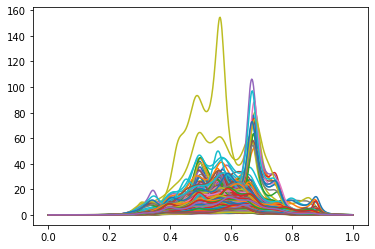

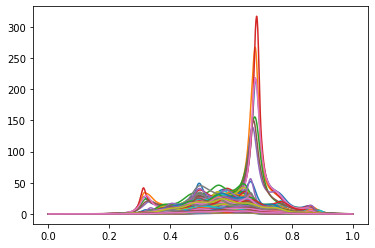

In [5]:
# loading the data of ADHD
filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+canale+"_p"+banda
mat = scipy.io.loadmat(filename_adhd)
PSD_ADHD=mat['avg']
df_Channel=pd.DataFrame(data=PSD_ADHD)
Channel=df_Channel.to_numpy(dtype=None, copy=False)
Channel = np.nan_to_num(Channel)
ADHD=skfda.FDataGrid(data_matrix=Channel)
ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

# loading the data of control
filename_control = home_path+"\Control_Matrici_medie\zona"+canale+"_p"+banda
mat = scipy.io.loadmat(filename_control)
PSD_control=mat['avg']
df_Channel=pd.DataFrame(data=PSD_control)
Channel=df_Channel.to_numpy(dtype=None, copy=False)
Channel = np.nan_to_num(Channel)
Control=skfda.FDataGrid(data_matrix=Channel)
Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

plot_adhd = ADHD.plot()
plot_control = Control.plot()

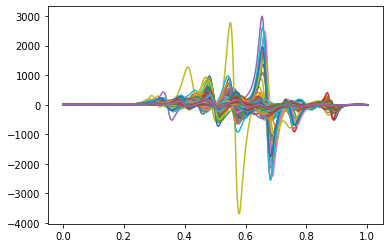

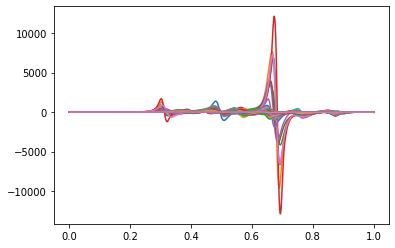

In [6]:
# computing the derivatives of the curves
ADHD_der=ADHD.derivative()
Control_der=Control.derivative()

plot_adhd_der = ADHD_der.plot()
plot_control_der = Control_der.plot()
    

### Computing the intergral of the absolute value of the first derivative
$$ I = \int \|f'(t)\| dt $$

Median: 24.187641869531944
Mean: 33.97126106604104
Starndard deviation: 33.59599897683493


{'whiskers': [<matplotlib.lines.Line2D at 0x2bd25f272b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2bd25f27850>,
 'boxes': [<matplotlib.lines.Line2D at 0x2bd25f0ff70>],
 'medians': [<matplotlib.lines.Line2D at 0x2bd25f27df0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2bd25f35100>],
 'means': []}

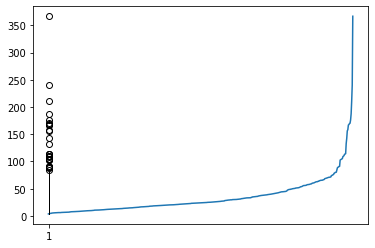

In [7]:
# integral of the derivative of the adhd group
ADHD_der_abs = ADHD_der
ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

n_adhd = ADHD_der_abs.data_matrix.shape[0]

int_adhd = np.empty(n_adhd)
for i in range(n_adhd):
    int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])

plt.plot(np.sort(int_adhd))
print("Median: "+str(np.median(int_adhd)))
print("Mean: "+str(np.mean(int_adhd)))
print("Starndard deviation: "+str(np.std(int_adhd)))

plt.boxplot(int_adhd)

Median: 24.202760240853724
Mean: 37.34111752216298
Starndard deviation: 58.177333684941516


{'whiskers': [<matplotlib.lines.Line2D at 0x2bd25f952e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2bd25f95880>,
 'boxes': [<matplotlib.lines.Line2D at 0x2bd25f95040>],
 'medians': [<matplotlib.lines.Line2D at 0x2bd25f95e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x2bd25fa3130>],
 'means': []}

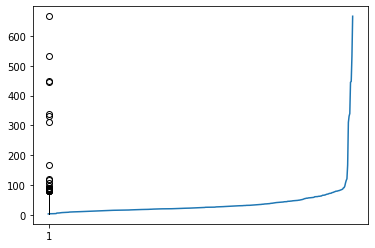

In [8]:
# integral of the derivative of the control group
Control_der_abs = Control_der
Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

n_cont = Control_der_abs.data_matrix.shape[0]

int_cont = np.empty(n_cont)
for i in range(n_cont):
    int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])

plt.plot(np.sort(int_cont))
print("Median: "+str(np.median(int_cont)))
print("Mean: "+str(np.mean(int_cont)))
print("Starndard deviation: "+str(np.std(int_cont)))

plt.boxplot(int_cont)


### Anova on the integrals

In [9]:
aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

ANOVA results: 
F statistics: 	1.2964092961844778
p_value: 	0.25514840595542515


### Same study extended to all the zones and frequential bands

In [10]:
# funzione per calcolare integrali delle derivate e fare anova tra i due gruppi

def AnovaIntDer(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # compute the derivatives of the functions
    ADHD_der=ADHD.derivative()
    Control_der=Control.derivative()

    # integral of the derivative of the adhd group
    ADHD_der_abs = ADHD_der
    ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

    n_adhd = ADHD_der_abs.data_matrix.shape[0]

    int_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])
        
    
    # print("ADHD:")
    # print("Median: "+str(np.median(int_adhd)))
    # print("Mean: "+str(np.mean(int_adhd)))
    # print("Starndard deviation: "+str(np.std(int_adhd)))

    # integral of the derivative of the control group
    Control_der_abs = Control_der
    Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

    n_cont = Control_der_abs.data_matrix.shape[0]

    int_cont = np.empty(n_cont)
    for i in range(n_cont):
        int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])

    
    # print("Control:")
    # print("Median: "+str(np.median(int_cont)))
    # print("Mean: "+str(np.mean(int_cont)))
    # print("Starndard deviation: "+str(np.std(int_cont)))

    # ANOVA

    #aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
    res = permutation_test((int_adhd, int_cont), statistic,
                       alternative='two-sided')
    
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    return res.pvalue


In [11]:
def Integrale(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # compute the derivatives of the functions
    ADHD_der=ADHD.derivative()
    Control_der=Control.derivative()

    # integral of the derivative of the adhd group
    ADHD_der_abs = ADHD_der
    ADHD_der_abs.data_matrix=np.abs(ADHD_der.data_matrix)

    n_adhd = ADHD_der_abs.data_matrix.shape[0]

    int_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        int_adhd[i]=scipy.integrate.simpson(np.transpose(ADHD_der_abs.data_matrix[i]), ADHD_der_abs.grid_points[0])
        
    
    # print("ADHD:")
    # print("Median: "+str(np.median(int_adhd)))
    # print("Mean: "+str(np.mean(int_adhd)))
    # print("Starndard deviation: "+str(np.std(int_adhd)))

    # integral of the derivative of the control group
    Control_der_abs = Control_der
    Control_der_abs.data_matrix=np.abs(Control_der.data_matrix)

    n_cont = Control_der_abs.data_matrix.shape[0]

    int_cont = np.empty(n_cont)
    for i in range(n_cont):
        int_cont[i]=scipy.integrate.simpson(np.transpose(Control_der_abs.data_matrix[i]), Control_der_abs.grid_points[0])

    
    # print("Control:")
    # print("Median: "+str(np.median(int_cont)))
    # print("Mean: "+str(np.mean(int_cont)))
    # print("Starndard deviation: "+str(np.std(int_cont)))

    # ANOVA

    #aov = scipy.stats.f_oneway(int_adhd,int_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    #res = permutation_test((int_adhd, int_cont), statistic, alternative='two-sided')
    return int_adhd, int_cont

In [12]:
p_val = np.empty((7,5))
p_val.shape

(7, 5)

In [13]:
for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaIntDer(canale, banda, home_path)   
    

In [14]:
print(pd.DataFrame(p_val))

        0       1       2       3       4
0  0.5286  0.4052  0.3312  0.1022  0.2952
1  0.0454  0.0394  0.0002  0.0002  0.2352
2  0.4528  0.5666  0.1252  0.1166  0.7752
3  0.6408  0.5594  0.6018  0.0728  0.0014
4  0.3272  0.2708  0.1088  0.2588  0.0224
5  0.1526  0.9322  0.3024  0.2476  0.0456
6  0.0002  0.0002  0.0032  0.0304  0.4020


## $L^2$ norm study

In [12]:
# funzione per calcolare norma L2 e fare anova tra i due gruppi

def AnovaNormLp(canale, banda, home_path, order=2):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # L2 norm of ADHD group
    n_adhd = ADHD.data_matrix.shape[0]

    norm_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        norm_adhd[i]=np.linalg.norm(ADHD.data_matrix[i], ord = order)

    # L2 norm of control group
    n_cont = Control.data_matrix.shape[0]

    norm_cont = np.empty(n_cont)
    for i in range(n_cont):
        norm_cont[i]=np.linalg.norm(Control.data_matrix[i], ord = order)

    # ANOVA

    #aov = scipy.stats.f_oneway(norm_adhd,norm_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))
    
    res = permutation_test((norm_adhd, norm_cont), statistic,
                       alternative='two-sided')
    return res.pvalue


In [13]:
def Norma(canale, banda, home_path, order=2):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # L2 norm of ADHD group
    n_adhd = ADHD.data_matrix.shape[0]

    norm_adhd = np.empty(n_adhd)
    for i in range(n_adhd):
        norm_adhd[i]=np.linalg.norm(ADHD.data_matrix[i], ord = order)

    # L2 norm of control group
    n_cont = Control.data_matrix.shape[0]

    norm_cont = np.empty(n_cont)
    for i in range(n_cont):
        norm_cont[i]=np.linalg.norm(Control.data_matrix[i], ord = order)

    # ANOVA

    #aov = scipy.stats.f_oneway(norm_adhd,norm_cont, axis=0)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    #res = permutation_test((norm_adhd, norm_cont), statistic, alternative='two-sided')
    return norm_adhd, norm_cont


In [17]:
p_val_norm = np.empty((7,5))

for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaNormLp(canale, banda, home_path)

print(pd.DataFrame(p_val))

        0       1       2       3       4
0  0.6820  0.6504  0.3608  0.0118  0.3410
1  0.0002  0.0012  0.0002  0.0002  0.1232
2  0.2532  0.1022  0.2542  0.2148  0.4512
3  0.8926  0.8962  0.1468  0.0526  0.0016
4  0.0204  0.2140  0.1850  0.2968  0.0410
5  0.6058  0.0620  0.4740  0.3442  0.0656
6  0.0002  0.0002  0.0062  0.0164  0.9768


In [14]:
# funzione per calcolare picchi fare anova tra i due gruppi

def AnovaPicco(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    Picco_ADHD=ADHD.data_matrix.max(1)
        
    # print("ADHD:")
    # print("Median: "+str(np.median(Picco_ADHD)))
    # print("Mean: "+str(np.mean(Picco_ADHD)))
    # print("Starndard deviation: "+str(np.std(Picco_ADHD)))

    Picco_Control=Control.data_matrix.max(1)

    # print("Control:")
    # print("Median: "+str(np.median(Picco_Control)))
    # print("Mean: "+str(np.mean(Picco_Control)))
    # print("Starndard deviation: "+str(np.std(Picco_Control)))

    # ANOVA

    #aov = scipy.stats.f_oneway(Picco_ADHD, Picco_Control)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))
    
    res = permutation_test((Picco_ADHD, Picco_Control), statistic,
                       alternative='two-sided')
    return res.pvalue


In [15]:
def Picco(canale, banda, home_path):
    
    # loading the data of ADHD
    filename_adhd = home_path+"\ADHD_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_adhd)
    PSD_ADHD=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_ADHD)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    ADHD=skfda.FDataGrid(data_matrix=Channel)
    ADHD.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    # loading the data of control
    filename_control = home_path+"\Control_Matrici_medie\zona"+str(canale)+"_p"+str(banda)
    mat = scipy.io.loadmat(filename_control)
    PSD_control=mat['avg']
    df_Channel=pd.DataFrame(data=PSD_control)
    Channel=df_Channel.to_numpy(dtype=None, copy=False)
    Channel = np.nan_to_num(Channel)
    Control=skfda.FDataGrid(data_matrix=Channel)
    Control.interpolation=skfda.representation.interpolation.SplineInterpolation(interpolation_order=3)

    Picco_ADHD=ADHD.data_matrix.max(1)
        
    # print("ADHD:")
    # print("Median: "+str(np.median(Picco_ADHD)))
    # print("Mean: "+str(np.mean(Picco_ADHD)))
    # print("Starndard deviation: "+str(np.std(Picco_ADHD)))

    Picco_Control=Control.data_matrix.max(1)

    # print("Control:")
    # print("Median: "+str(np.median(Picco_Control)))
    # print("Mean: "+str(np.mean(Picco_Control)))
    # print("Starndard deviation: "+str(np.std(Picco_Control)))

    # ANOVA

    #aov = scipy.stats.f_oneway(Picco_ADHD, Picco_Control)
    # print("ANOVA results: \nF statistics: \t"+str(aov.statistic)+"\np_value: \t"+ str(aov.pvalue))

    #res = permutation_test((Picco_ADHD, Picco_Control), statistic, alternative='two-sided')
    return Picco_ADHD, Picco_Control


In [20]:
p_val_picco = np.empty((7,5))

for canale in range(1,8):
    for banda in range(1,6):
        p_val[(canale-1), (banda-1)] = AnovaPicco(canale, banda, home_path)

print(pd.DataFrame(p_val))

        0       1       2       3       4
0  0.7554  0.2928  0.1538  0.0290  0.2234
1  0.0880  0.1310  0.0004  0.0002  0.9514
2  0.2384  0.4092  0.7544  0.0978  0.7872
3  0.9306  0.5938  0.4330  0.0506  0.0004
4  0.3982  0.7732  0.2830  0.1536  0.0210
5  0.2098  0.9840  0.9844  0.7440  0.0310
6  0.0002  0.0002  0.0150  0.0030  0.1934


In [16]:
etichette=np.append(np.ones((555, 1), dtype=int),np.zeros((427, 1), dtype=int))

#Integrali
    #Frontali
    
int_fro_gamma_adhd, int_fro_gamma_cont = Integrale(2, 1, home_path)
int_fro_gamma=np.append(int_fro_gamma_adhd, int_fro_gamma_cont)

int_fro_beta_adhd, int_fro_beta_cont = Integrale(2, 2, home_path)
int_fro_beta=np.append(int_fro_beta_adhd, int_fro_beta_cont)

int_fro_alpha_adhd, int_fro_alpha_cont = Integrale(2, 3, home_path)
int_fro_alpha=np.append(int_fro_alpha_adhd, int_fro_alpha_cont)

int_fro_theta_adhd, int_fro_theta_cont = Integrale(2, 4, home_path)
int_fro_theta=np.append(int_fro_theta_adhd, int_fro_theta_cont)

    #Laterali
    
int_ldx_gamma_adhd, int_ldx_gamma_cont = Integrale(7, 1, home_path)
int_ldx_gamma=np.append(int_ldx_gamma_adhd, int_ldx_gamma_cont)

int_ldx_beta_adhd, int_ldx_beta_cont = Integrale(7, 2, home_path)
int_ldx_beta=np.append(int_ldx_beta_adhd, int_ldx_beta_cont)

int_ldx_alpha_adhd, int_ldx_alpha_cont = Integrale(7, 3, home_path)
int_ldx_alpha=np.append(int_ldx_alpha_adhd, int_ldx_alpha_cont)

int_ldx_theta_adhd, int_ldx_theta_cont = Integrale(7, 4, home_path)
int_ldx_theta=np.append(int_ldx_theta_adhd, int_ldx_theta_cont)

#Norma L2

    #Frontali
    
norm_fro_gamma_adhd, norm_fro_gamma_cont = Norma(2, 1, home_path)
norm_fro_gamma=np.append(norm_fro_gamma_adhd, norm_fro_gamma_cont)

norm_fro_beta_adhd, norm_fro_beta_cont = Norma(2, 2, home_path)
norm_fro_beta=np.append(norm_fro_beta_adhd, norm_fro_beta_cont)

norm_fro_alpha_adhd, norm_fro_alpha_cont = Norma(2, 3, home_path)
norm_fro_alpha=np.append(norm_fro_alpha_adhd, norm_fro_alpha_cont)

norm_fro_theta_adhd, norm_fro_theta_cont = Norma(2, 4, home_path)
norm_fro_theta=np.append(norm_fro_theta_adhd, norm_fro_theta_cont)

    #Laterali
    
norm_ldx_gamma_adhd, norm_ldx_gamma_cont = Norma(7, 1, home_path)
norm_ldx_gamma=np.append(norm_ldx_gamma_adhd, norm_ldx_gamma_cont)

norm_ldx_beta_adhd, norm_ldx_beta_cont = Norma(7, 2, home_path)
norm_ldx_beta=np.append(norm_ldx_beta_adhd, norm_ldx_beta_cont)

norm_ldx_alpha_adhd, norm_ldx_alpha_cont = Norma(7, 3, home_path)
norm_ldx_alpha=np.append(norm_ldx_alpha_adhd, norm_ldx_alpha_cont)

norm_ldx_theta_adhd, norm_ldx_theta_cont = Norma(7, 4, home_path)
norm_ldx_theta=np.append(norm_ldx_theta_adhd, norm_ldx_theta_cont)

#Picchi

    #Frontali

picco_fro_alpha_adhd, picco_fro_alpha_cont = Picco(2, 3, home_path)
picco_fro_alpha=np.append(picco_fro_alpha_adhd, picco_fro_alpha_cont)

picco_fro_theta_adhd, picco_fro_theta_cont = Picco(2, 4, home_path)
picco_fro_theta=np.append(picco_fro_theta_adhd, picco_fro_theta_cont)

    #Laterali
    
picco_ldx_gamma_adhd, picco_ldx_gamma_cont = Picco(7, 1, home_path)
picco_ldx_gamma=np.append(picco_ldx_gamma_adhd, picco_ldx_gamma_cont)

picco_ldx_beta_adhd, picco_ldx_beta_cont = Picco(7, 2, home_path)
picco_ldx_beta=np.append(picco_ldx_beta_adhd, picco_ldx_beta_cont)

picco_ldx_alpha_adhd, picco_ldx_alpha_cont = Picco(7, 3, home_path)
picco_ldx_alpha=np.append(picco_ldx_alpha_adhd, picco_ldx_alpha_cont)

picco_ldx_theta_adhd, picco_ldx_theta_cont = Picco(7, 4, home_path)
picco_ldx_theta=np.append(picco_ldx_theta_adhd, picco_ldx_theta_cont)

In [17]:
d = {'1': int_fro_gamma, '2': int_fro_beta, '3': int_fro_alpha, '4': int_fro_theta, '5': int_ldx_gamma, '6': int_ldx_beta,
     '7': int_ldx_theta, '8':int_ldx_alpha, '9': norm_fro_gamma, '10': norm_fro_beta, '11': norm_fro_alpha, '12': norm_fro_theta,
     '13': norm_ldx_gamma, '14': norm_ldx_beta, '15': norm_ldx_alpha, '16': norm_ldx_theta, '17': picco_fro_alpha, 
     '18': picco_fro_theta, '19': picco_ldx_gamma, '20': picco_ldx_beta, '21': picco_ldx_alpha, '22': picco_ldx_theta
    }
dati = pd.DataFrame(data=d)
print(dati.values)

[[ 21.96899822 190.78505912 927.15196046 ...  58.9810524  309.61099243
  882.26391602]
 [ 20.17463185 167.36862643 753.31369457 ...  84.58054352 423.90936279
  702.18060303]
 [ 18.67612471 146.56251621 819.39402735 ...  80.46448517 348.54934692
  674.20874023]
 ...
 [ 21.03880673  66.91010902 237.89916909 ...  39.59145355 103.2126236
  414.69226074]
 [ 21.33542843  96.12401576 277.11710037 ...  67.89276886 402.32202148
  747.53582764]
 [ 16.25861804  81.89753388 245.73580182 ...  34.62201691 123.08894348
  507.11120605]]


In [18]:
dati_train,dati_test,etich_train,etich_test  = train_test_split(dati.values,etichette,random_state=0)

etich_train=np.ravel(etich_train)

clf = LogisticRegression(penalty='l2', max_iter=10000000000000000)
clf.fit(dati_train,etich_train)
etich_pred_train = clf.predict(dati_train)
etich_pred_test = clf.predict(dati_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(etich_train,etich_pred_train))

print(accuracy_score(etich_test,etich_pred_test))

#clf = LogisticRegression(random_state=0).fit(dati.values, etichette)
#clf.score(dati.values, etichette)

0.6684782608695652
0.6138211382113821


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(etich_test,etich_pred_test)

array([[60, 47],
       [48, 91]], dtype=int64)

In [20]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000000000000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [21]:
import numpy as np
import pandas as pd

# Statistical libraries
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Classification methods
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [22]:
X=dati
y=etichette

In [23]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,\
    test_size= 1/3.0, random_state =1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True)

In [24]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [25]:
n_estimators = 50

methods = {
    'Lasso':LogisticRegression(penalty="l1",C=100, random_state=1234, max_iter=300, solver="liblinear"),
    'NaiveBayes':GaussianNB(),
    'k-NN(5)':KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'),
    'Decision Tree':DecisionTreeClassifier(max_depth=None),
    'Bagging(Tree)':BaggingClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimators),
    'Bagging(kNN)':BaggingClassifier(KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree'),n_estimators=n_estimators),
    'Random Forest':RandomForestClassifier(n_estimators=n_estimators,max_depth=3,oob_score=True),
    'Extremely Randomized Trees':ExtraTreesClassifier(n_estimators=n_estimators,max_depth=3),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimators)
}

In [26]:
xval_results = {}
roc_results = {}
feature_importance_model = {}

method = []
accuracy_mean = []
accuracy_std = []
precision = []
recall = []
f1 = []
auc = []

for method_name in methods:
    
    
    clf = methods[method_name];
    
    # evaluate the model using crossvalidation
    xval_score = cross_val_score(clf,X,y,cv=crossvalidation)
    
    # store the raw results of crossvalidation that we might want to use for t-test/mann-whitney comparison
    xval_results[method_name] = xval_score
    
    # compute the basic statistics
    accuracy_mean.append(np.average(xval_score))
    accuracy_std.append(np.std(xval_score))
    
    clf.fit(X_train,y_train)

    # if the mode can return an evaluation of feature importance we store it to analyze it later
    if hasattr(clf, 'feature_importances_'):
            feature_importance_model[method_name] = (clf,clf.feature_importances_)
    
    # compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
    yp = clf.predict(X_test)
    
    # ask for the probability values
    yprob = clf.predict_proba(X_test)
    
    # computes the data needed to draw the ROC curve
    fpr_nb, tpr_nb, thresholds = roc_curve(y_true=y_test, y_score = yprob[:,1], pos_label=1)
    
    # computes the AUC 
    roc_auc = roc_auc_score(y_true=y_test, y_score = yprob[:,1])
    auc.append(roc_auc)

    # store the information to plot the ROC curves afterwards
    roc_results[method_name] = (fpr_nb, tpr_nb, thresholds, roc_auc)
    
    precision.append(precision_score(y_test,yp))
    recall.append(recall_score(y_test,yp))
    f1.append(f1_score(y_test, yp))
    
    print("%40s"%method_name)
    print("========================================")
    print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
    print("\tAccuracy (Test) %.3f"%precision_score(y_test, yp))
    print("\t      Precision %.3f"%precision_score(y_test, yp))
    print("\t      Recall    %.3f"%recall_score(y_test, yp))
    print("\t      F1        %.3f"%f1_score(y_test, yp))
    print("\n")

    method.append(method_name)

                                   Lasso
	  Accuracy (CV) 0.635 0.030
	Accuracy (Test) 0.760
	      Precision 0.760
	      Recall    0.632
	      F1        0.690


                              NaiveBayes
	  Accuracy (CV) 0.519 0.044
	Accuracy (Test) 0.793
	      Precision 0.793
	      Recall    0.229
	      F1        0.355


                                 k-NN(5)
	  Accuracy (CV) 0.740 0.042
	Accuracy (Test) 0.770
	      Precision 0.770
	      Recall    0.731
	      F1        0.750


                           Decision Tree
	  Accuracy (CV) 0.751 0.048
	Accuracy (Test) 0.751
	      Precision 0.751
	      Recall    0.632
	      F1        0.686


                           Bagging(Tree)
	  Accuracy (CV) 0.688 0.027
	Accuracy (Test) 0.817
	      Precision 0.817
	      Recall    0.776
	      F1        0.796


                            Bagging(kNN)
	  Accuracy (CV) 0.717 0.044
	Accuracy (Test) 0.781
	      Precision 0.781
	      Recall    0.746
	      F1        0.763


                

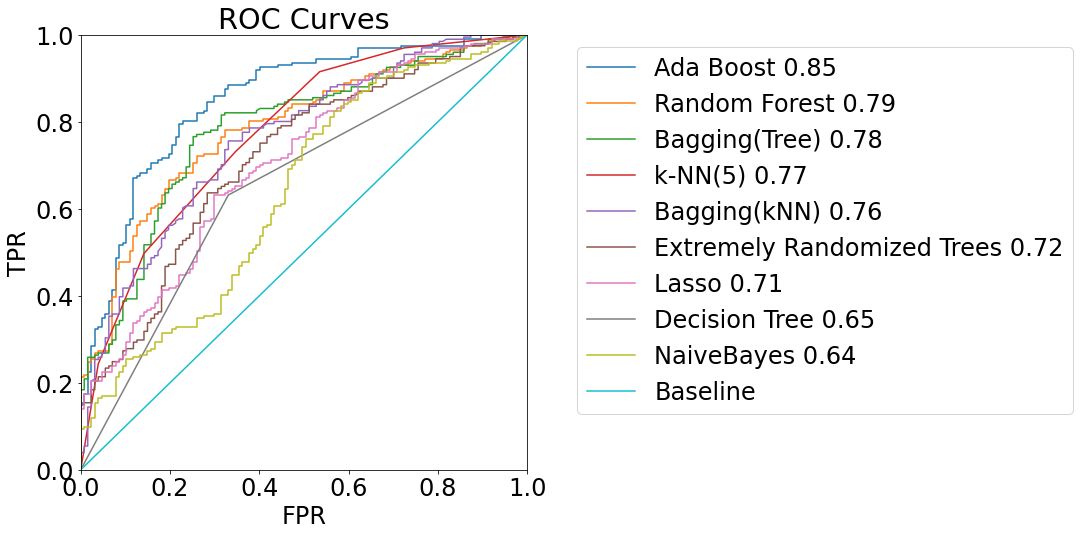

In [27]:
# we sort the AUC values so to have a better legend
sorted_roc_results = sorted(roc_results.items(), key=lambda x: x[1][3], reverse=True)

plt.figure(1, figsize=(8, 8));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
for result in sorted_roc_results:
    plt.plot(result[1][0], result[1][1],label=result[0]+' %.2f'%result[1][3])


# plt.plot(fpr,thresholds,label='Thresholds')
plt.plot([0.0,1.0],[0.0,1.0],label='Baseline')
plt.yticks(np.arange(0.0,1.01,.2))
plt.title('ROC Curves')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.legend(bbox_to_anchor=(2.25, 1.0))

plt.show();

In [28]:
result_summary = pd.DataFrame({'Model':method,'Accuracy (Mean)':accuracy_mean,'Accuracy (Std)':accuracy_std,'Precision':precision,'Recall':recall,'F1':f1,'AUC':auc})
result_summary.to_csv('Coseunpoacaso.csv')

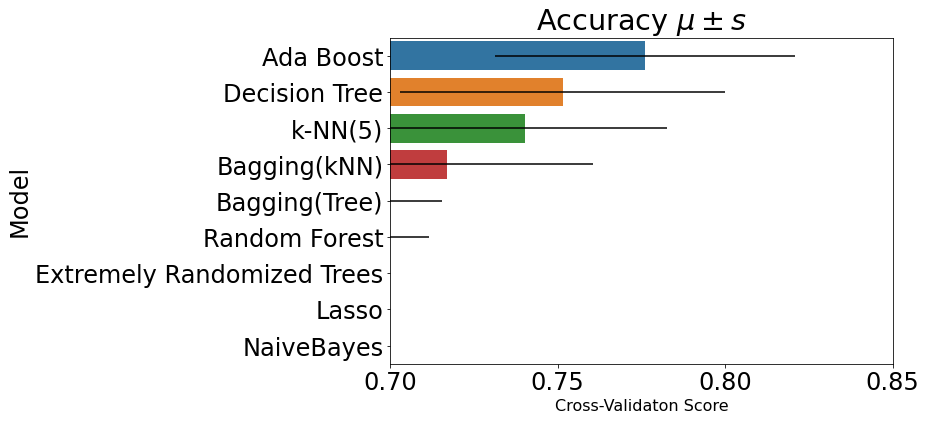

In [29]:
f, axe = plt.subplots(1,1, figsize=(9,6))

result_summary.sort_values(by=['Accuracy (Mean)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy (Mean)', y='Model', data = result_summary, xerr=result_summary['Accuracy (Std)'], ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_title("Accuracy $\mu\pm s$")
axe.set_xlim(0.7,0.85)
plt.show()

In [30]:
df_crossvalidation = pd.DataFrame(xval_results)

In [31]:
df_crossvalidation.drop(columns=['NaiveBayes','Lasso','Extremely Randomized Trees','Random Forest','Bagging(Tree)'],inplace=True)

In [32]:
confidence_level = 0.95

no_variables = len(df_crossvalidation.columns)

p_value = np.zeros((no_variables,no_variables))

for first,first_model in enumerate(df_crossvalidation.columns):
    
    p_value[first,first] = 1.0
    
    for second in range(first+1,(len(df_crossvalidation.columns))):

        second_model = df_crossvalidation.columns[second]
        
        paired_test = stats.ttest_rel(df_crossvalidation[first_model], df_crossvalidation[second_model])
    
        p_value[first,second] = paired_test[1]
        p_value[second,first] = paired_test[1]
        
        if (paired_test[1]<(1-confidence_level)):
            print("%15s vs %15s => Difference is statistically significant (cf %3.2f p-value=%.4f)"%(first_model,second_model,confidence_level*100,paired_test[1]))

   Bagging(kNN) vs       Ada Boost => Difference is statistically significant (cf 95.00 p-value=0.0036)


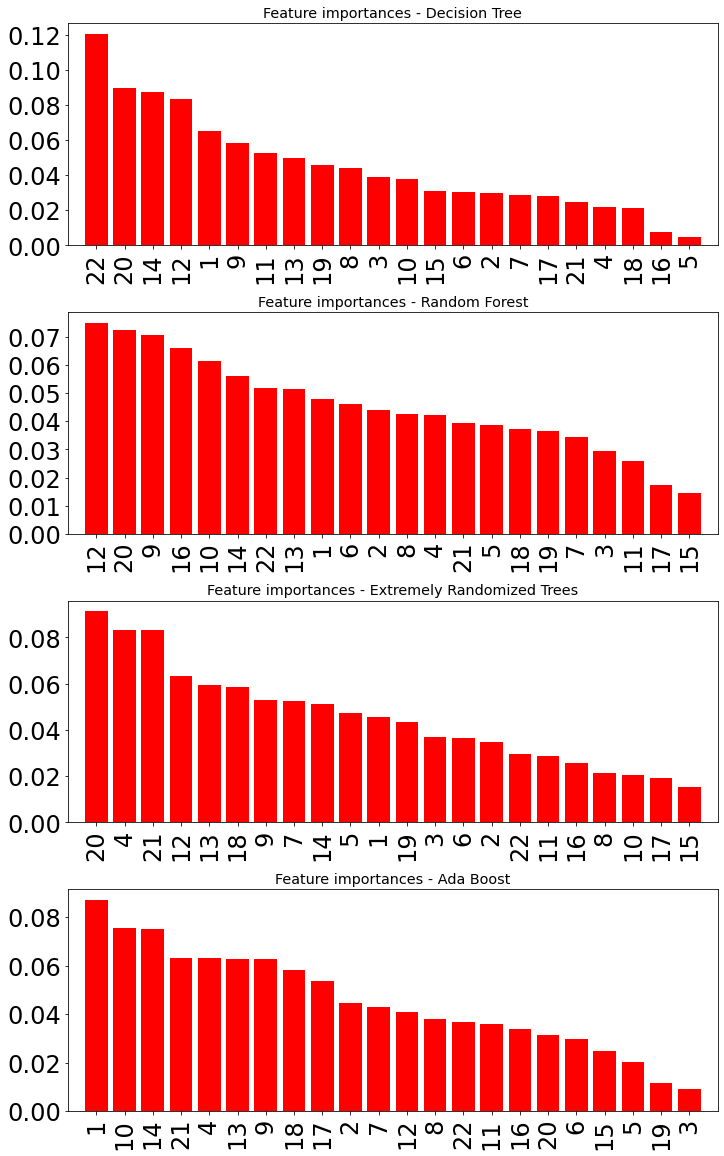

In [33]:
plot_idx = 1

plt.subplots(len(feature_importance_model),1,figsize=(10,4*len(feature_importance_model)))
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)


for model_name in feature_importance_model:
    model = feature_importance_model[model_name][0]
    
    # importance of features
    importances = model.feature_importances_
    
    # indeces of the variables
    indices = np.argsort(importances)[::-1]

    plt.subplot(len(feature_importance_model),1,plot_idx)
    
    # 
    plt.title("Feature importances - "+model_name)
    plt.xticks(range(X.shape[1]),X.columns[indices],rotation='vertical')


    plt.xlim([-1, X.shape[1]])

#     if hasattr(model, 'estimators_'):
#         std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#         plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")# plt.xticks(range(X.shape[1]), indices)
#     else:
    plt.bar(range(X.shape[1]), importances[indices], color="r")


    plot_idx = plot_idx + 1
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

# Voting classifier

In [34]:
estimators = [x for x in methods.items()]

In [35]:
%%time
clf = VotingClassifier(estimators=estimators, voting='soft')

method_name = 'Voting'

# evaluate the model using crossvalidation
cross_val_score(clf,X,y,cv=crossvalidation)
    
# store the raw results of crossvalidation that we might want to use for t-test/mann-whitney comparison
xval_results['Voting'] = xval_score
    
# compute the basic statistics
accuracy_mean.append(np.average(xval_score))
accuracy_std.append(np.std(xval_score))
    
clf.fit(X_train,y_train)
    
# compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
yp = clf.predict(X_test)

# ask for the probability values
yprob = clf.predict_proba(X_test)

# computes the data needed to draw the ROC curve
fpr_nb, tpr_nb, thresholds = roc_curve(y_true=y_test, y_score = yprob[:,1], pos_label=1)

# computes the AUC 
roc_auc = roc_auc_score(y_true=y_test, y_score = yprob[:,1])
auc.append(roc_auc)

# store the information to plot the ROC curves afterwards
roc_results[method_name] = (fpr_nb, tpr_nb, thresholds, roc_auc)

precision.append(precision_score(y_test,yp))
recall.append(recall_score(y_test,yp))
f1.append(f1_score(y_test, yp))

print("%10s\tAccuracy  %.3f %.3f"%(method_name,np.average(xval_score),np.std(xval_score)))
print("          \tPrecision %.3f"%precision_score(y_test, yp))
print("          \tRecall    %.3f"%recall_score(y_test, yp))
print("          \tF1        %.3f"%f1_score(y_test, yp))

method.append(method_name)

    Voting	Accuracy  0.776 0.045
          	Precision 0.829
          	Recall    0.652
          	F1        0.730
CPU times: total: 12.9 s
Wall time: 12.9 s


In [36]:
result_summary_extra = pd.DataFrame({'Model':method,'Accuracy (Mean)':accuracy_mean,'Accuracy (Std)':accuracy_std,'Precision':precision,'Recall':recall,'F1':f1,'AUC':auc})
result_summary_extra.to_csv('LoanSafety-Summary-Extra.csv')

In [37]:
result_summary_extra

,Model,Accuracy (Mean),Accuracy (Std),Precision,Recall,F1,AUC
0,Lasso,0.635467,0.030098,0.760479,0.631841,0.690217,0.706546
1,NaiveBayes,0.519285,0.044099,0.793103,0.228856,0.355212,0.637599
2,k-NN(5),0.740353,0.042420,0.769634,0.731343,0.750000,0.773769
3,Decision Tree,0.751495,0.048470,0.751479,0.631841,0.686486,0.650566
4,Bagging(Tree),0.688415,0.027112,0.816754,0.776119,0.795918,0.781780
5,Bagging(kNN),0.716914,0.043642,0.781250,0.746269,0.763359,0.761782
6,Random Forest,0.685281,0.026124,0.740909,0.810945,0.774347,0.785012
7,Extremely Randomized Trees,0.645558,0.036613,0.695122,0.850746,0.765101,0.716222
8,Ada Boost,0.775995,0.044788,0.823529,0.835821,0.829630,0.849610
9,Voting,0.775995,0.044788,0.829114,0.651741,0.729805,0.820151


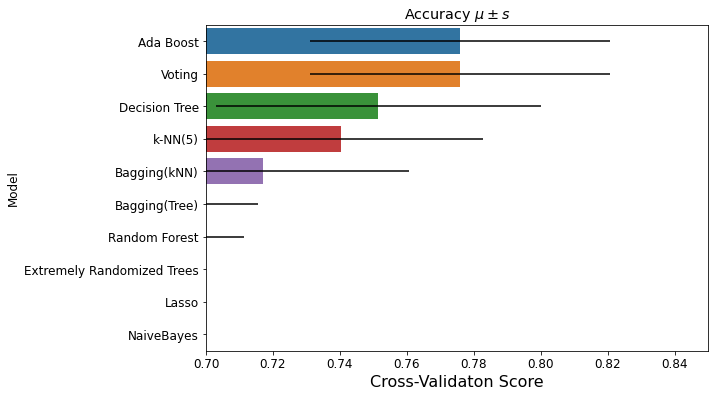

In [38]:
f, axe = plt.subplots(1,1, figsize=(9,6))

result_summary_extra.sort_values(by=['Accuracy (Mean)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy (Mean)', y='Model', data = result_summary_extra, xerr=result_summary_extra['Accuracy (Std)'], ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_title("Accuracy $\mu\pm s$")
axe.set_xlim(0.7,0.85)
plt.show()

In [39]:
stack_train = pd.DataFrame()
stack = {}

for method_name in methods:
    clf = methods[method_name]
    clf.fit(X_train,y_train)
    stack[method_name] = clf
    stack_train[method_name] = clf.predict(X_train)


In [40]:
meta = LogisticRegression(penalty="l1",C=100, random_state=1234, max_iter=300, solver="liblinear")
meta.fit(stack_train,y_train)

LogisticRegression(C=100, max_iter=300, penalty='l1', random_state=1234,
                   solver='liblinear')

In [41]:
stack_train.head()

,Lasso,NaiveBayes,k-NN(5),Decision Tree,Bagging(Tree),Bagging(kNN),Random Forest,Extremely Randomized Trees,Ada Boost
0,0,0,1,1,1,1,1,1,1
1,0,0,1,1,1,1,1,1,1
2,1,0,1,1,0,1,1,1,1
3,0,0,1,1,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1


In [42]:
stack_test = pd.DataFrame()

for method_name in stack:
    stack_test[method_name] = methods[method_name].predict(X_test)

yp = meta.predict(stack_test)

In [43]:
print("Accuracy %.3f"%(accuracy_score(y_test, yp)))
print("Precision %.3f"%precision_score(y_test, yp))
print("Recall %.3f"%recall_score(y_test, yp))

Accuracy 0.652
Precision 0.738
Recall 0.672
